In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import itertools
import time

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from auxiliar_func import preprocessing, downsampling, cross_validation
from plot_func import *

In [2]:
df = pd.read_csv('Census-Income-KDD.csv')
target = 'income_50k'
df_tr, df_te = train_test_split(df, test_size=0.3, random_state=42)

## Cross validation to test the preprocessing parameters

In [8]:
params = {
    'scaling': ['standard', None],
    'imputation': ['mode'],
    'cat_age': [False],
    'target_freq': [0.8, 0.85, 0.9]
}

results = pd.DataFrame(columns=['scaling', 'imputation', 'cat_age', 'target_freq', 'accuracy', 'f1_macro', 'precision_macro', 'recall_macro'])

for combination in list(itertools.product(*params.values())):
    print(f"Adjusting for {combination}")
    par_tr = {k:v for k,v in zip(params.keys(), combination)}
    par_tr['remove_duplicates'] = True

    # we remove the parameter that modifies the test dataset
    par_te = par_tr.copy()
    par_te['remove_duplicates'] = False
    par_te['target_freq'] = None

    logreg = LogisticRegression(max_iter=1000, random_state=42, solver='newton-cholesky')

    cross_val_results = cross_validation(logreg, df_tr, par_tr, par_te, cv = 4,
                                       scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'])
    results = pd.concat([results, pd.DataFrame([list(combination) + list(cross_val_results.values())],
                                                  columns=['scaling', 'imputation', 'cat_age', 'target_freq', 'accuracy', 'f1_macro', 'precision_macro', 'recall_macro'])])
    
results.to_csv('results_log_regression.csv', index=False)

Adjusting for ('standard', 'mode', False, 0.8)
Adjusting for ('standard', 'mode', False, 0.85)
Adjusting for ('standard', 'mode', False, 0.9)
Adjusting for (None, 'mode', False, 0.8)
Adjusting for (None, 'mode', False, 0.85)
Adjusting for (None, 'mode', False, 0.9)


In [4]:
df_tr_pre = preprocessing(df_tr, scaling=None, imputation='mode', cat_age=False, target_freq=0.8)
df_te_pre = preprocessing(df_te, scaling=None, imputation='mode', remove_duplicates=False, cat_age=False)

df_tr_pre, df_te_pre = df_tr_pre.align(df_te_pre, join='left', axis=1, fill_value=0)
df_tr_pre.shape, df_te_pre.shape

## Adjusting a logistic regression model

In [6]:
X_train, y_train = df_tr_pre.drop(target, axis=1), df_tr_pre[target]
X_test, y_test = df_te_pre.drop(target, axis=1), df_te_pre[target]

# adjust a logistic regression model to the data
logreg = LogisticRegression(max_iter=1000, random_state=42, solver='newton-cholesky')
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

### Accuracy metrics:

Accuracy score:  0.9424294568722121


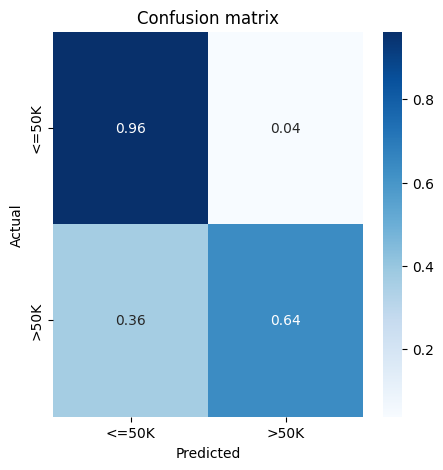

In [7]:
print('Accuracy score: ', accuracy_score(y_test, y_pred))
plot_conf_matrix(y_test, y_pred)